# Testing Reflection and Mutual Coupling Systematics Mitigation

Jacob Burba, Bobby Pascua, and the HERA Validation Team

## Setup and Metadata

### Abstract

This test is meant to serve as an independent validation of the reflection and mutual coupling systematics mitigation that is included in the `HERA-Team/H1C_IDR2` power spectrum pre-processing pipeline. The performance of the systematics mitigation pipeline is tested within and shown to suppress reflections in autocorrleations by at least two orders of magnitude and mutual coupling in cross-correlations almost entirely.  An important caveat for all tests contained in this notebook is that the parameter values for the various components of the systematics pipeline have been optimized for noisy datasets.  Whereas the datasets used within are noiseless and are simply signal + systematics.

### Imports

In [1]:
%matplotlib inline
import copy
import glob
import os
import sys
import h5py
import yaml

import astropy
from astropy import constants, units
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from datetime import datetime
from pathlib import Path

import hera_sim
import hera_pspec
import pyuvdata
from pyuvdata import UVData
import uvtools
from uvtools.dspec import gen_window
from uvtools.plot import waterfall
from uvtools.utils import FFT, fourier_freqs

if hera_sim.version.version.startswith('0'):
    from hera_sim.rfi import _listify
else:
    from hera_sim.utils import _listify

sys.path.append('/users/heramgr/hera_software/hera-validation/test-series/4/')
from tools import sim_prep

/lustre/aoc/projects/hera/jburba/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


In [2]:
for _ in range(2):
    plt.rcParams.update({'font.size' : 14})

### Description

Last executed: {{print(datetime.now())}}

- **Major Step Description:** Test pipeline components related to reflection calibration and mutual coupling (crosstalk) removal
- **Minor Variation Description:**
  - Use RIMEz to simulate visibilities including GLEAM, eGSM, and a $P(k) = Ak^{-2}$ EoR power spectrum
  - Add cable reflections, a reflection spectrum, and mutual coupling systematic to the simulated visibilities
  - Run the signal + systematics (corrupted) visibilities through the systematics mitigation pipeline
  - Obtain delay power spectra via `hera_pspec`, with parameters based on H1C IDR2 analysis pipeline, on the various visibilities
  - Compare power spectra before and after the systematics pipeline
- **Pipelines Tested:** 
  - `H1C_IDR2/pipeline/preprocess_data.py`, specifically the `xtalk_sub` and `ref_cal` functions
  - `hera_pspec`
- **Criteria**:
  1. Demonstrate suppression of reflection systematics in the power spectrum
  2. Demonstrate suppression of mutual coupling systematics in the power spectrum

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. The suppression of reflections, most easily visible in autocorrelation power spectra, is clearly visible.  At its worst, the reflection calibration pipeline is capable of reducing bright reflections, which are highly confused with adjacent reflections in the reflection spectrum, by at least two orders of magnitude.  Some residual reflections are visible in the power spectrum after the systematics pipeline.  But, looking at cross-correlation power spectra, which are being used to obtain the upcoming H1C IDR2.2 upper limits, this level of suppression appears to be sufficient.


2. Suppression of the mutual coupling (also referred to as cross coupling or cross-talk) systematic works fine, in the case of noiseless data as used here.  There is signal loss during this step at a significant range of delays in the power spectrum.  However, this is somewhat unsurprising as this particular step in the systematics pipeline is quite sensitive to signal loss and has been optimized to operate on noisy data where the noise floor is several orders of magnitude above the underlying signal.  The most substantial signal loss here occurs near the baseline delay horizon in the foreground pitchfork.  This is expected behavior, as the delay range used in the modeling of the mutual coupling systematic extends into the pitchfork.  As a demonstration of this expectation, power spectra corresponding to data with no systematics run through the systematics pipeline show signal loss of a similar magnitude after being run through the mutual coupling filter.


Other notes of interest:
- For noiseless datasets, the mutual coupling systematic removal seems to produce substantial signal loss (as much as 20%) out to large values of delay at ~4000 ns.  This is likely an artifact of the optimization of the mutual coupling parameters for noisy data with a noise floor much larger than the underlying power spectrum at these delays.  The delay at which the recovered power spectrum becomes approximately equal to the trun power spectrum increases as a function of increasing EW baseline length.

- The systematics pipeline seems to perform best for the (515, 695) spectral window in that there is the least amount of signal loss, with the exception being the pitchfork for reasons discussed above, even when dealing with noiseless datasets.

Important Caveats:
- The systematics pipeline is typically run on noisy datasets that have been LST binned.  The datasets here are noiseless and have not been LST binned.  They are instead representative of a single night's worth of data.  Because of this, signal loss is expected after running the mutual coupling filter, especially near the foreground pitchfork.

### Software

HERA software used in this validation test, with associate git commit hash:
* ``hera_sim``:   {{hera_sim.version.git_hash}}
* ``pyuvdata``:   2.1.2.dev20+ged2bc74
* ``hera_pspec``: {{hera_pspec.version.git_hash}}
* ``uvtools``:    {{uvtools.version.git_hash}}

Versions of other software used in this validation test:
import astropy
from astropy import constants, units
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline
* ``numpy``: {{np.version.version}}
* ``astropy``: {{astropy.version.version}}

### Data

The following paths reflect the exact locations of the raw (true) datasets used in this test.  These datasets are representative of foregrounds + EoR for a single night taken from Validation `test-4.0.0`.

In [3]:
# Path to visibility files
vis_data_path = "/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458111/"
vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen*sum.true.uvh5"))
)

### Convenience Functions

In [4]:
def plot_waterfalls(data, freqs, times, windows=None, mode='log', 
                    cmap='inferno', dynamic_range=None, limit_drng='all',
                    baseline=None, horizon_color='magenta', plot_limits=None,
                    freq_window_kwargs=None, time_window_kwargs=None):
    """
    Make a 2x2 grid of waterfall plots.
    
    This function takes a 2D array of visibility data (in units of Jy), as well 
    as the corresponding frequency and time arrays (in units of Hz and JD, respectively), 
    and makes a 2x2 grid of plots where each plot shows each one of the possible choices 
    for Fourier transforming along an axis. The upper-left plot is in the frequency-time 
    domain; the upper-right plot is in the frequency-fringe-rate domain; the lower-left 
    plot is in the delay-time domain; and the lower-right plot is in the delay-fringe-rate 
    domain.
    
    Parameters
    ----------
    data : ndarray, shape=(NTIMES,NFREQS)
        Array containing the visibility to be plotted. Assumed to be in units of Jy. 
        
    freqs : ndarray, shape=(NFREQS,)
        Array containing the observed frequencies. Assumed to be in units of Hz.
        
    times : ndarray, shape=(NTIMES,)
        Array containing the observed times. Assumed to be in units of JD.
        
    windows : tuple of str or str, optional
        Choice of taper to use for the fringe-rate and delay transforms. Must be 
        either tuple, list, or string. If a tuple or list, then it must be either 
        length 1 or length 2; if it is length 2, then the zeroth entry is the taper 
        to be applied along the time axis for the fringe-rate transform, with the 
        other entry specifying the taper to be applied along the frequency axis 
        for the delay transform. Each entry is passed to uvtools.dspec.gen_window. 
        If ``windows`` is a length 1 tuple/list or a string, then it is assumed 
        that the same taper is to be used for both axes. Default is to use no 
        taper (or, equivalently, a boxcar).
        
    mode : str, optional
        Plotting mode to use; passed directly to uvtools.plot.waterfall. Default is 
        'log', which plots the base-10 logarithm of the absolute value of the data. 
        
    cmap : str or matplotlib.colors.Colormap, optional
        Colormap to use for visualizing the data. Default is to use the inferno 
        colormap.
        
    dynamic_range : float, optional
        Number of orders of magnitude to use for limiting the dynamic range of the 
        colormap. This parameter is only used if ``mode`` is set to 'log' and the 
        ``limit_drng`` parameter is not None. If the conditions to use this 
        parameter are met, then the vmin parameter is set to be dynamic_range orders 
        of magnitude less than vmax. That is, if vmax = np.log10(np.abs(data)).max(), 
        then vmin = vmax - dynamic_range. Default is to not limit the dynamic range.
        
    limit_drng : str or array-like of str, optional
        Choice of which plots for which to limit the dynamic range. Possible choices 
        are 'freq', 'time', 'delay', and 'fringe_rate'. If any of these are chosen, 
        then the plots that have one of the axes match the specified choices will 
        have their dynamic range limited. For example, passing 'delay' to this 
        parameter will limit the dynamic range for the delay-time and delay-fringe-rate 
        plots. Default is to limit the dynamic range for all plots. 
        
    baseline : float or array-like of float, optional
        Baseline length or baseline position in units of meters. If this parameter is 
        specified, then the geometric horizon is plotted as a vertical line in the 
        delay-space plots. Default is to not plot the geometric horizon.
        
    horizon_color : str, 3-tuple, or 4-tuple, optional
        Color to use for the vertical lines indicating the geometric horizon. This 
        may either be a string, 3-tuple specifying RGB values, or 4-tuple specifying 
        RGBA values. Default is to use magenta.
        
    plot_limits : dict, optional
        Dictionary whose keys may be any of ('freq', 'time', 'delay', 'fringe-rate') 
        and whose values are length 2 array-like objects specifying the bounds for 
        the corresponding axis. For horizontal axes, these should be ordered from low 
        to high; for vertical axes, these should be ordered from high to low. For 
        example, passing {'delay' : (-500, 500)} will limit the delay axis to values 
        between -500 and +500 nanoseconds. Frequency units should be in Hz; time 
        units should be in JD; delay units should be in ns; fringe rate units should 
        be in mHz. Default is to use the full extent of each axis.
        
    freq_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        frequency taper. Default is to pass no keyword arguments.
        
    time_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        time taper. Default is to pass no keyword arguments.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib.figure.Figure object containing the plots.
    """
    # do some data prep
    freq_window_kwargs = freq_window_kwargs or {}
    time_window_kwargs = time_window_kwargs or {}
    if windows is not None:
        if type(windows) not in (str, list, tuple):
            raise ValueError("windows parameter must be a string, tuple, or list.")
        if len(_listify(windows)) > 2:
            raise ValueError("Only up to two windows may be specified.")
        if len(_listify(windows)) == 2:
            time_window = gen_window(windows[0], times.size, **time_window_kwargs)
            freq_window = gen_window(windows[1], freqs.size, **freq_window_kwargs)
        else:
            if not isinstance(windows, str):
                windows = windows[0]
            time_window = gen_window(windows, times.size, **time_window_kwargs)
            freq_window = gen_window(windows, freqs.size, **freq_window_kwargs)
    else:
        time_window = gen_window(None, times.size, **time_window_kwargs)
        freq_window = gen_window(None, freqs.size, **freq_window_kwargs)
        
    time_window = time_window[:, None]
    freq_window = freq_window[None, :]
    data_fr = FFT(data * time_window, axis=0)
    data_dly = FFT(data * freq_window, axis=1)
    data_fr_dly = FFT(FFT(data * time_window, axis=0) * freq_window, axis=1)
    
    fringe_rates = fourier_freqs(times * units.day.to('s')) * 1e3 # mHz
    dlys = fourier_freqs(freqs) * 1e9 # ns
    plot_freqs = freqs / 1e6
    jd = int(np.floor(times[0]))
    plot_times = times - jd
    
    if baseline is not None:
        horizon = np.linalg.norm(baseline) / constants.c.value * 1e9
        
    fig = plt.figure(figsize=(14,10))
    axes = fig.subplots(2,2)
    for j, ax in enumerate(axes.ravel()):
        column = j % 2
        row = j // 2
        xlabel = "Frequency [MHz]" if row == 0 else "Delay [ns]"
        ylabel = "Time Since JD%d [days]" % jd if column == 0 else "Fringe Rate [mHz]"
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        xlimits, ylimits = None, None
        if column == 0 and row == 0:
            use_data = data
            extent = (
                plot_freqs.min(), plot_freqs.max(), plot_times.max(), plot_times.min()
            )
            vis_label = r"$\log_{10}|V(\nu, t)|$ [Jy]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 0 and row == 1:
            use_data = data_dly
            extent = (dlys.min(), dlys.max(), plot_times.max(), plot_times.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, t)|$ [Jy Hz]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 1 and row == 0:
            use_data = data_fr
            extent = (
                plot_freqs.min(), plot_freqs.max(), fringe_rates.max(), fringe_rates.min()
            )
            vis_label = r"$\log_{10}|\tilde{V}(\nu, f)|$ [Jy s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
        else:
            use_data = data_fr_dly
            extent = (dlys.min(), dlys.max(), fringe_rates.max(), fringe_rates.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
            
        xlimits = xlimits or extent[:2]
        ylimits = ylimits or extent[2:]
        
        if dynamic_range is not None and mode == 'log':
            vmax = np.log10(np.abs(use_data)).max()
            vmin = vmax - dynamic_range
        else:
            vmin, vmax = None, None
            
        clip_drng = False
        if limit_drng == 'all':
            limit_drng = ("freq", "time", "delay", "fringe_rate")
        if "time" in limit_drng:
            if column == 0:
                clip_drng = True
        if "freq" in limit_drng:
            if row == 0:
                clip_drng = True
        if "delay" in limit_drng:
            if row == 1:
                clip_drng = True
        if "fringe_rate" in limit_drng:
            if column == 1:
                clip_drng = True
                
        if not clip_drng:
            vmin, vmax = None, None
            
        cbar_label = vis_label if mode == 'log' else "Phase [rad]"
        fig.sca(ax)
        cax = waterfall(
            use_data, extent=extent, mode=mode, vmin=vmin, vmax=vmax, cmap=cmap
        )
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
        if baseline is not None and row == 1:
            ax.axvline(horizon, color=horizon_color, ls='--')
            ax.axvline(-horizon, color=horizon_color, ls='--')
        
        _ = fig.colorbar(cax, label=cbar_label)
        
    return fig

## Simulating Crosstalk and Cable Reflections

The mutual coupling (also referred to as cross-talk or xtalk for short) mitigation techniques in `H1C_IDR2/pipeline/preprocess_data.py` place a cutoff on the lower bound of acceptable baseline fringe-rates.  This ensures that the mutual coupling systematic can be properly separated from the non-zero fringe-rate sky signal.  As such, the EW projected baseline length is the only baseline axis we need to explore.  To improve the speed at which the systematics pipeline is performed, we will create datasets that use only a subset of the baselines in the RIMEz datasets from `test-4.0.0`.  The process of baseline selection is performed in the following cells.

In [5]:
uvd = UVData()
uvd.read(vis_files[0], read_data=False)
# Compress by redundancy
uvd.compress_by_redundancy()
# Select only first time
uvd.select(times=uvd.time_array[0])

# Find all baselines with |v| < 1 m
EW_bl_inds = np.where(np.abs(uvd.uvw_array[:, 1]) < 1.0)[0]
bls = [uvd.baseline_to_antnums(uvd.baseline_array[EW_bl_inds[i_bl]]) for i_bl in range(EW_bl_inds.size)]
autos = [(ant, ant) for ant in np.unique(np.array(bls).flatten())[1:]]
bls += autos
print('Baselines to keep: {}'.format(bls))

Telescope RIMEz calculation is not in known_telescopes.


Baselines to keep: [(36, 41), (23, 27), (11, 14), (0, 0), (0, 1), (0, 2), (1, 1), (2, 2), (11, 11), (14, 14), (23, 23), (27, 27), (36, 36), (41, 41)]


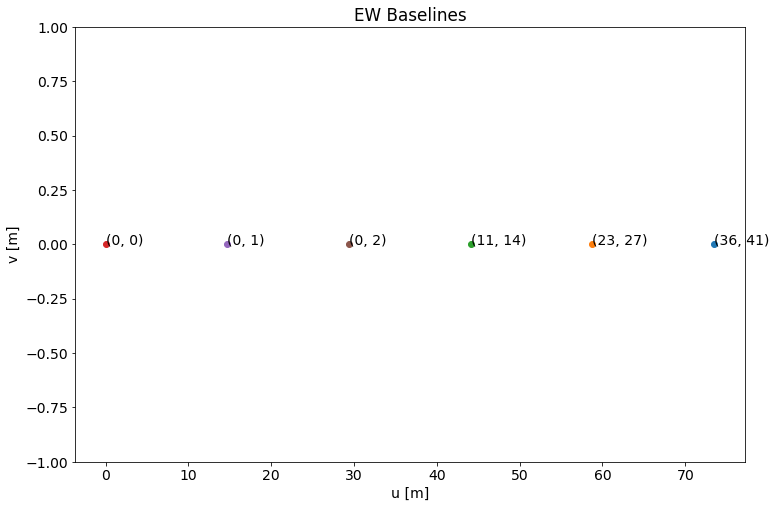

In [6]:
fig = plt.figure(figsize=(12, 8))
for i_bl, (u, v, w) in enumerate(uvd.uvw_array[EW_bl_inds]):
    plt.plot(u, v, marker='o')
    plt.annotate(uvd.baseline_to_antnums(uvd.baseline_array[EW_bl_inds[i_bl]]), (u, v))
plt.xlabel('u [m]')
plt.ylabel('v [m]')
plt.ylim([-1, 1])
plt.title('EW Baselines');

**Figure 1** | EW baselines that will be used in the dataset.

In [7]:
# Load in the data
# Only use linear polarizations; need to load in a file first for this
uvd = UVData()
uvd.read_uvh5(vis_files[0], read_data=False)
use_pols = uvd.get_pols()
x_orientation = 'e' # this might be wrong, but doesn't really matter for now
use_pols = [pol for pol in use_pols if pol[0] == pol[1]]
use_pols = [pyuvdata.utils.polstr2num(pol, x_orientation) for pol in use_pols]

# Actually load the data
uvd = UVData()
uvd.read(vis_files, polarizations=use_pols, keep_all_metadata=False, bls=bls)
# Collect metadata
lsts_rad = np.unique(uvd.lst_array)
lsts_hrs = lsts_rad * 12.0 / np.pi
freqs = uvd.freq_array[0]
times = np.unique(uvd.time_array)

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_tele

The spectral windows (spws) used here are taken from the `H1C_IDR2` analysis pipeline and the corresponding systematics mitigation parameters have been chosen and optimized for these particular spectral windows where there is minimal flagging.

In [8]:
# Store metadata in dictionaries for easy transport
metadata_dic = {
    'freqs' : uvd.freq_array[0],
    'lsts_rad' : np.unique(uvd.lst_array),
    'lsts_hrs' : np.unique(uvd.lst_array) * 12.0 / np.pi,
    'times_jd' : np.unique(uvd.time_array)
}

params = {
    'spws' : [(175, 335), (515, 695), (705, 810)],
    'bls' : uvd.get_antpairs(),
    'blps' : [(bl, bl) for bl in bls],
    'edgecut_low' : 0,
    'edgecut_hi' : 0
}

bl_dic = {
    (0, 1) : '14 m EW',
    (0, 2) : '29 m EW',
    (11, 14) : '44 m EW',
    (23, 27) : '59 m EW',
    (36, 41) : '73 m EW'
}

The systematics are simulated using tools available in `hera_sim.sigchain`. In particular, we will use the `gen_cross_coupling_xtalk` and `gen_reflection_gains` functions from that module. The parameters chosen to characterize the mutual coupling (here referred to as crosstalk) and cable reflections (and subsequently remove these systematics) will be motivated and informed by the following sources: 
* http://reionization.org/wp-content/uploads/2013/03/HERA064_reflection_memo.pdf (reflections) 
* https://arxiv.org/pdf/1909.11732.pdf (systematics paper; theory)
* https://arxiv.org/pdf/1909.11733.pdf (systematics paper; data)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/validation/xtalk_removal.ipynb
    * (crosstalk removal, we'll use the SVD-based approach with GPR smoothing)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/pipeline/prms_preprocess.yaml
    * (reference for choosing parameter values for pre-pspec, post-analysis processing)
* https://docs.google.com/presentation/d/1LYd9fn-5mkY4u0KtOzbnDo1nJQRQekQuuibuVawk9bw/edit#slide=id.p
    * (pspec pipeline flowchart)

Important note regarding how cross-coupling is modeled:  
If $V_{ij}$ is a visibility formed by baseline $\vec{b}_{ij}$ with $i\neq j$, then the cross-coupling visibility (that is, the contribution to the visibility from cross-coupling) is given, to leading order in smallness, by  
$$
V_{ij}^{xtalk} = \epsilon_{ij}^*V_{ii} + \epsilon_{ji}^*V_{jj},
$$
where $\epsilon_{ij}$ is a reflection coefficient given by  
$$
\epsilon_{ij} = A_{ij}\mathrm{e}^{i(2\pi\nu\tau_{ij} + \phi_{ij})}.
$$
The above equations are taken from the theory systematics paper (second item in the bulleted list). The `gen_xtalk` function below is basically copied directly from the crosstalk removal notebook (third item in the bulleted list).
  
<b>Note</b>: according to the equations from the systematics paper, we should be conjugating the reflection coefficient (so mapping both the delay and the phase to the negative of their values), but the `gen_xtalk` function doesn't exactly do that.

### Add Systematics

The paramters used for adding in the cable reflections, reflection spectrum, and the mutual coupling systematic are taken from `test-4.0.0`.  There are a total of 20 reflections added for the reflection spectrum in the range of ~200 - 1000 ns and two cable reflections at 200 and 1200 ns.  The mutual coupling systematic is injected in the delay range of 900 - 1300 ns.

In [9]:
cfg_file = "/lustre/aoc/projects/hera/Validation/test-4.0.0/setup/sim_config.yaml"
with open(cfg_file, "r") as cfg:
    config = yaml.load(cfg.read())
_ = config.pop("noise")
_ = config.pop("gains")

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [10]:
corrupt_uvd, systematics, parameters = sim_prep.apply_systematics(copy.deepcopy(uvd), **config)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


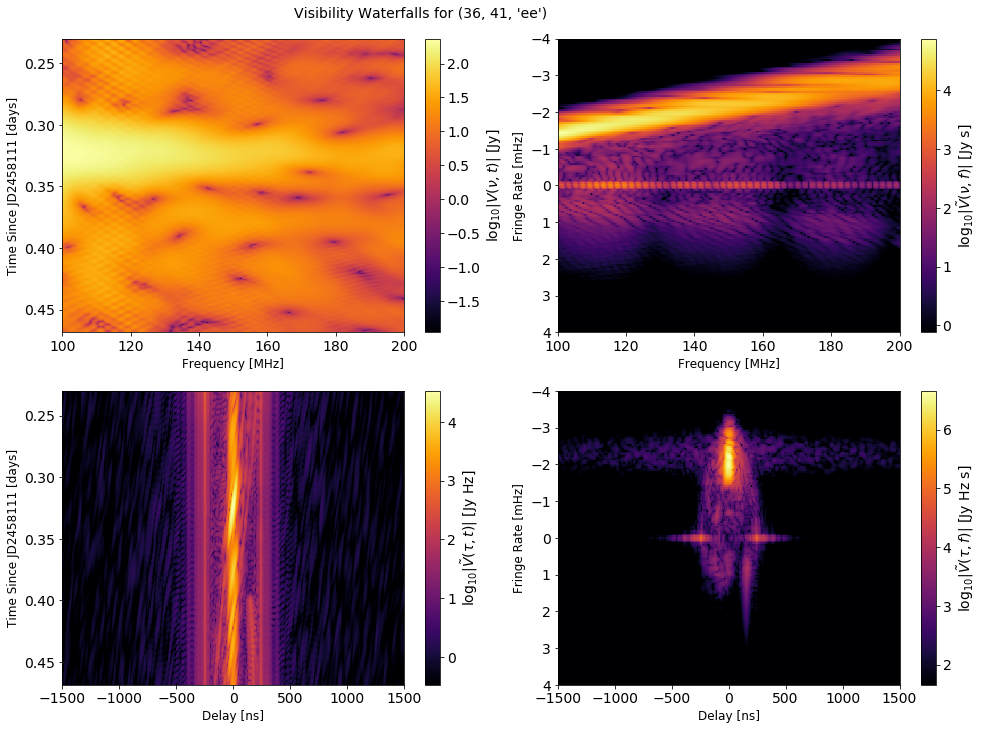

In [11]:
crosskey = (36, 41, 'ee')
crosscorr_vis = uvd.get_data(crosskey)

time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}
freq_window_kwargs = {"edgecut_low" : 50, "edgecut_high" : 50}

fig = plot_waterfalls(
    crosscorr_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)

# add a title to the figure
title = "Visibility Waterfalls for %s" % str(crosskey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()

**Figure 2** | Data before systematics injection for a {{bl_dic[(36, 41)]}} baseline.

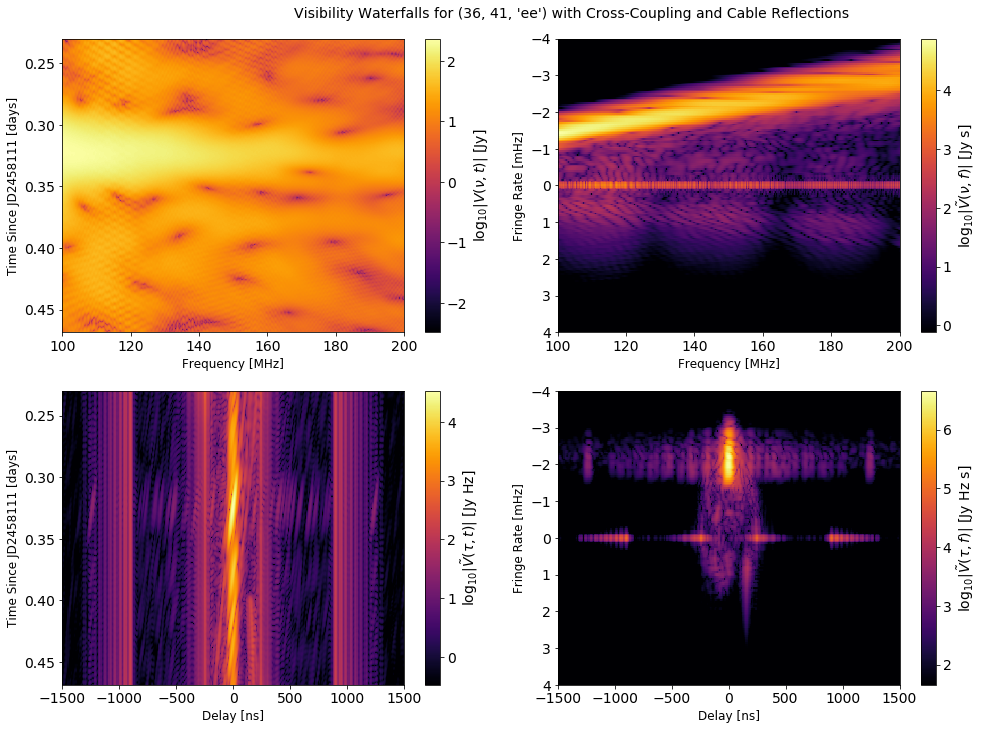

In [12]:
crosskey = (36, 41, 'ee')
crosscorr_vis = corrupt_uvd.get_data(crosskey)

time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}
freq_window_kwargs = {"edgecut_low" : 50, "edgecut_high" : 50}

fig = plot_waterfalls(
    crosscorr_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)

# add a title to the figure
title = "Visibility Waterfalls for %s with Cross-Coupling and Cable Reflections" % str(crosskey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()

**Figure 3** | Data after systematics injected for a {{bl_dic[(36, 41)]}} baseline.

### Divide and save files

In [13]:
# Chunk up the LST axis back into 32 equal segments as in the original data files
times_jd_per_file = metadata_dic['times_jd'].reshape((len(vis_files),
                                                      metadata_dic['times_jd'].size//len(vis_files)))
print(times_jd_per_file.shape)

(32, 60)


In [14]:
# Save true datasets
true_vis_paths = []
out_dir = Path("/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/")
for times, infile in zip(times_jd_per_file, vis_files):
    uvd_temp = uvd.select(times=times, inplace=False)
    outfile = (Path(infile).stem + '.uvh5')
    true_vis_paths.append(str(out_dir / outfile))
    print('Writing to {}'.format(out_dir / outfile))
    uvd_temp.write_uvh5(str(out_dir / outfile))
    del uvd_temp

Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.22991.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.23737.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.24482.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.25228.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.25974.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.26719.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.27465.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.28211.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.28956.sum.true.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visib

In [15]:
# Save corrupted datasets
corrupt_vis_paths = []
out_dir = Path("/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/")
for times, infile in zip(times_jd_per_file, vis_files):
    uvd_temp = corrupt_uvd.select(times=times, inplace=False)
    outfile = (Path(infile).stem + '.uvh5').replace('true', 'sys')
    corrupt_vis_paths.append(str(out_dir / outfile))
    print('Writing to {}'.format(out_dir / outfile))
    uvd_temp.write_uvh5(str(out_dir / outfile))
    del uvd_temp

Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.22991.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.23737.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.24482.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.25228.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.25974.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.26719.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.27465.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.28211.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2458111.28956.sum.sys.uvh5
Writing to /lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/z

## Systematics Removal

The systematics removal is performed using `HERA-Team/H1C_IDR2/preprocess_data.py` and pulls all analysis parameters from the yaml file `HERA-Team/H1C_IDR2/preprocess_params.yaml`.  The parameters used here for cross talk removal (`xtalk_sub`) and reflection calibration (`ref_cal`) were pulled from

```
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/preprocess_params.yaml
```

and are representative of the current analysis parameters being used in the upcoming upper limits paper.  Those parameters, for reference, are as follows:


In [16]:
temp_uvd = UVData()
temp_uvd.read('/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/'
              'preproc/zen.2458111.22991.sum.sysX.uvh5',
              read_data=False)
print(temp_uvd.history)

time series generated from /lustre/aoc/projects/hera/zmartino/hera_validation/test-0.1/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.rimezh5  Read/written with pyuvdata version: 2.0.1.  Downselected to specific polarizations using pyuvdata.  Downselected to specific antennas using pyuvdata.
Antennas adjusted to optimally match H1C antennas.  Downselected to specific times using pyuvdata.  Read/written with pyuvdata version: 1.4.2.  Git origin: https://github.com/RadioAstronomySoftwareGroup/pyuvdata.git.  Git hash: 6eaa2d32d7656adad3021d221712f47745efce46.  Git branch: master.  Git description: v1.4-316-g6eaa2d32.  Downselected to specific baselines, polarizations using pyuvdata. Combined data along baseline-time axis using pyuvdata. Combined data along baseline-time axis using pyuvdata. Combined data along baseline-time axis using pyuvdata. Combined data along baseline-time axis using pyuvdata. Combined data along baseline-time axis using pyuvdata. Combined data a

Telescope RIMEz calculation is not in known_telescopes.


## Power Spectrum Retrieval

### hera_pspec utility functions

In [17]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies
flag_nchan_low, flag_nchan_high = (params['edgecut_low'],
                                   params['edgecut_hi'])
freq_slice = slice(flag_nchan_low, -flag_nchan_high)

# load beam-dependent normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()]
    Omegapp = h5f['Omegapp'][()]

Omega = {'xx': Omega, 'yy': Omega}
Omegapp = {'xx': Omegapp, 'yy': Omegapp}
    
beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp,
                                               np.unique(metadata_dic['freqs']),
                                               cosmo=cosmo)

def calc_pspec(vis_file, outfile, spw_ranges=None, bls=None, polarizations=None, taper="bh"):
    uvd = UVData()
    uvd.read(vis_file, bls=bls, polarizations=polarizations)

    if not bls is None:
        blpairs = [(bl, bl) for bl in bls]
    else:
        blpairs = None
        
    if not uvd.x_orientation is None:
        uvd.x_orientation = None
    
    if not polarizations is None:
        pol_pairs = [('xx', 'xx')]
    else:
        pol_pairs = [(pol, pol) for pol in polarizations]
    _ = hera_pspec.pspecdata.pspec_run([uvd, uvd], outfile, file_type="uvh5",
                                       taper=taper, beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges,
                                       blpairs=blpairs, pol_pairs=pol_pairs,
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)
    del(uvd)

In [18]:
# Paths to visibility files post systematics pipeline
recovered_true_paths = [df.replace('visibilities', 'visibilities/preproc').replace('true', 'trueX')
                        for df in true_vis_paths]
recovered_vis_paths = [df.replace('visibilities', 'visibilities/preproc').replace('sys', 'sysX')
                       for df in corrupt_vis_paths]

The labels used for the datasets in the subsequent power spectrum plots are described as follows:
 - `true`: true, uncorrupted visibilities
 - `corrupt`: true + systematics (reflections and mutual coupling)
 - `recovered`: corrupt visibilities after being run through the systematics pipeline
 - `recovered (true)`: true visibilities after being run through the systematics pipeline
 
The true visibilities with no systematics were also run through the systematics pipeline to demonstrate that signal loss near the horizon of the baseline is expected.  This is because the chosen delay range for modeling the mutual coupling signal cuts slightly into the pitchfork at the baseline delay horizon.  Thus, some of the power in the pitchfork will be removed even when no mutual coupling systematic is present in the dataset being pushed through the systematics pipeline.

In [19]:
taper = 'bh'
signal_types = ['true', 'corrupt', 'recovered', 'recovered.true']

all_vis_files = [true_vis_paths,
                 corrupt_vis_paths,
                 recovered_vis_paths,
                 recovered_true_paths]
calc_ps = False
    
spw_str = '{}spws'.format(len(params['spws']))

ps_dir = Path('/lustre/aoc/projects/hera/Validation/test-3.2.0/pspec/')
pspec_files = [os.path.join(
                    ps_dir,
                    'zen.{:.0f}.sum.{}.{}.{}.psc'.format(metadata_dic['times_jd'][0],
                                                         signal_type,
                                                         spw_str,
                                                         taper)
               )
               for signal_type in signal_types]

if calc_ps:
    for vis_files, pspec_file in zip(all_vis_files, pspec_files):
        calc_pspec(vis_files,
                   pspec_file,
                   spw_ranges=params['spws'],
                   bls=params['bls'],
                   polarizations=['xx'],
                   taper=taper)

In [20]:
# Load in power spectra as uvpspec objects
uvps = {}
keys = ['true', 'corrupt', 'recovered', 'recovered.true']
for key, pspec_file in zip(keys, pspec_files):
    psc = hera_pspec.PSpecContainer(pspec_file, keep_open=False)
    uvps[key] = psc.get_pspec('dset0_dset1', 'dset0_x_dset1')

In [22]:
def plot_pspec_waterfalls(bl, uvps, params, metadata_dic, bl_dic):
    """
    Plots power spectrum waterfalls from a
    dictionary object containing uvpspec objects
    for the antenna pair supplied by `bl`.
    """
    freqs = metadata_dic['freqs']
    lsts_hrs = metadata_dic['lsts_hrs']
    spws = params['spws']
    nspws = len(spws)
    ntimes = lsts_hrs.size

    nrows = nspws
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4 * nrows))
    axs = np.array(axs)

    for ax in axs[:, 0]:
        ax.set_ylabel('LST [hrs]')

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw, spw in enumerate(params['spws']):
            kparas = uvps['true'].get_kparas(i_spw)
            nkmodes = kparas.squeeze().size
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            delays = kparas / tau_to_kpara * 1.0e9
            delays_xlim = [delays.min(), delays.max()]
            extent = [delays.min(), delays.max(),
                      lsts_hrs.max(), lsts_hrs.min()]
            
            ps_key = (i_spw, (bl, bl), 'xx')
            
            # Plot flags for spw
            ax = axs[i_spw, 0]
            cax = ax.imshow(np.log10(uvps['true'].get_data(ps_key).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ h$^{-3}$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('True')
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, 'spw = {}'.format(spw), transform=ax.transAxes,
                    fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

            ax = axs[i_spw, 1]
            cax = ax.imshow(np.log10(uvps['corrupt'].get_data(ps_key).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ h$^{-3}$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('Corrupt')

            ax = axs[i_spw, 2]
            cax = ax.imshow(np.log10(uvps['recovered'].get_data(ps_key).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ h$^{-3}$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('Recovered')

            for ax in axs[i_spw]:
                if i_spw == nspws - 1: ax.set_xlabel(r'$\tau$ [ns]')
                ax.set_xlim(delays_xlim)
                # Twin axis for plotting kparallels
                ax2 = plt.twiny(ax)
                ax2.set_xlim(delays_xlim)
                ax2.set_xticklabels([np.round(dly * tau_to_kpara / 1.0e9, decimals=1)
                                     for dly in ax2.get_xticks()])
                if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')

    fig.tight_layout()
    plt.subplots_adjust(top=0.875)
    if bl in bl_dic.keys():
        bl_str = 'a ' + bl_dic[bl] + ' Baseline'
    else:
        bl_str = 'Autocorrelation Baseline {}'.format(bl)
    fig.suptitle('Delay Power Spectra for {}'.format(bl_str), fontsize=14)

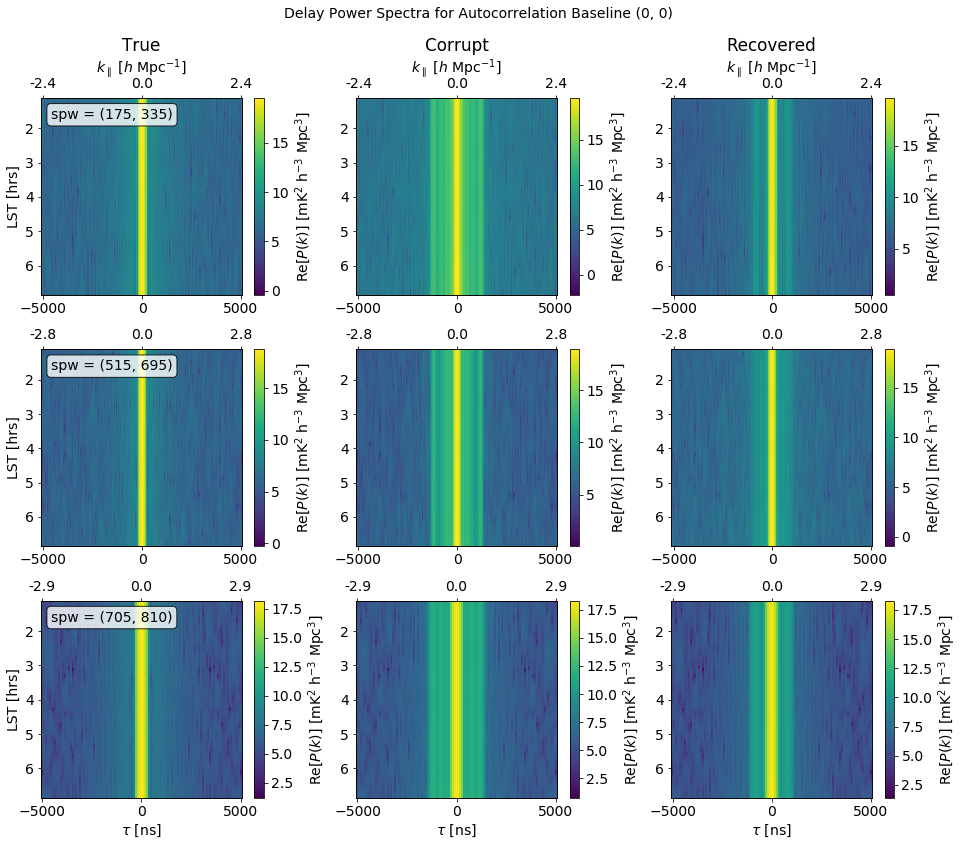

In [23]:
bl = (0, 0)
plot_pspec_waterfalls(bl, uvps, params, metadata_dic, bl_dic)

**Figure 4** | Delay power spectrum waterfalls per spw (one spw per row) for the true (left), corrupt (middle), and recovered (run through systematics pipeline; right) datasets for an autocorrelation baseline.

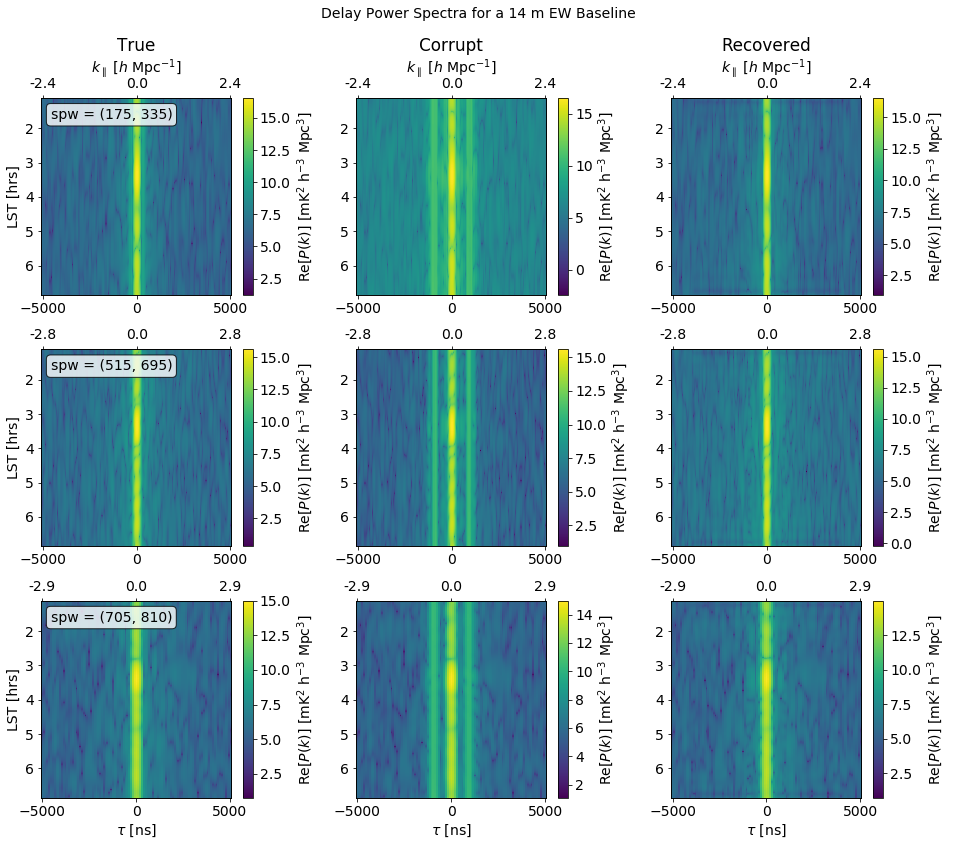

In [24]:
bl = (0, 1)
plot_pspec_waterfalls(bl, uvps, params, metadata_dic, bl_dic)

**Figure 5** | Delay power spectrum waterfalls per spw (one spw per row) for the true (left), corrupt (middle), and recovered (run through systematics pipeline; right) datasets for a 14 m EW baseline.

Average the power spectra over the time axis using the built in `average_spectra` function of $\texttt{hera_pspec}$.

In [25]:
# Setup a dictionary to hold time-averaged pspec objects
uvps_tavg = {}
for key in uvps.keys():

    # Extract uvpspec object from uvps dic
    uvps_tavg[key] = copy.deepcopy(uvps[key])

    # Average delay spectra over time using bad_ints as weights
    uvps_tavg[key].average_spectra(time_avg=True)

In [26]:
def plot_time_averaged_pspec_spectra(uvps_tavg, params,
                                     metadata_dic, cosmo,
                                     bl_dic, peak_norm=False,
                                     bl=None, spw_ind=None,
                                     plot_frac_diff=False,
                                     max_delay_ns=None, ylims=None,
                                     text_loc=(0.05, 0.9), fontsize=14,
                                     top=0.875, keys=None):
    """
    Plots time-averaged delay power spectra from
    a dictionary containing uvpspec objects.
    """
    lsts_hrs = metadata_dic['lsts_hrs']
    freqs = metadata_dic['freqs']
    spws = params['spws']
    ntimes = lsts_hrs.size
    if keys is None:
        keys = uvps_tavg.keys()
    
    rows = 0
    if isinstance(bl, (list, np.ndarray)):
        bls = bl
        rows = len(bls)
        single_bl = False
        if spw_ind is None:
            spw_ind = 0
    else:
        rows = 1
        single_bl = True
    
        if not bl is None:
            bl_key = bl + ('xx',)
        else:
            bl = params['bls'][0]
            bl_key = bl + ('xx',)
    
    if spw_ind is not None:
        spws = spws[spw_ind : spw_ind + 1]
        nspws = 1
        if rows == 0:
            rows = 1
    else:
        nspws = len(spws)
        rows = len(spws)
    
    if not ylims is None and len(ylims) == 1 and rows > 1:
        ylims = [ylims[0] for _ in range(rows)]
    
    plot_width = 13.5
    plot_height = 3
    if rows == 1:
        plot_height *= 1.5
    fig = plt.figure(figsize=(plot_width, plot_height * rows))
    gs = GridSpec(rows, 2)

    fontsize = 14
    linestyle_dic = {
        'true' : '-',
        'corrupt' : '-',
        'recovered' : '-',
        'recovered.true' : '--'
        }
    linecolor_dic = {
        'true' : 'k',
        'corrupt' : 'C0',
        'recovered' : 'C1',
        'recovered.true' : 'C1'
        }

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_row in range(rows):
            
            if len(spws) > 1 or single_bl:
                i_spw = i_row
            else:
                i_spw = 0
                bl = bls[i_row]
            spw = spws[i_spw]
            
            # Get delays and kparas
            delays = uvps_tavg['true'].get_dlys(i_spw) * 1.0e9
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            kparas = delays * 1.0e-09 * tau_to_kpara
            
            # Plot delay power spectrum for spw
            ax = fig.add_subplot(gs[i_row, 0])

            if max_delay_ns is None:
                delays_xlim = [delays[delays.size//2], delays[-1]]
                tick_inds = np.linspace(delays.size//2, delays.size - 1, 6).astype('int')
            else:
                delays_xlim = [delays[delays.size//2], max_delay_ns]
                max_delay_ind = np.argmin(np.abs(delays - max_delay_ns))
                tick_inds = np.linspace(delays.size//2, max_delay_ind, 6).astype('int')
            
            ps_key = (i_spw, (bl, bl), 'xx')
            
            for i_key, key in enumerate(keys):
                if peak_norm:
                    norm = 1.0 / uvps_tavg[key].get_data(ps_key)[0].real.max()
                else:
                    norm = 1.0
                if 'noisy' in key:
                    label = None
                elif key == 'recovered.true':
                    label = 'recovered (true)'
                else:
                    label = key
                ax.plot(delays,
                        uvps_tavg[key].get_data(ps_key)[0].real * norm,
                        c=linecolor_dic[key],
                        linestyle=linestyle_dic[key],
                        label=label)

            ax.set_yscale('log')
            ax.set_ylabel(r'$P(k)$ [mK$^2$ h$^{-3}$ Mpc$^3$]')
            ax.legend(loc='upper right', frameon=False) #, ncol=len(list(uvps_tavg.keys())))
            ax.set_xlim(delays_xlim)
            ax.grid(which='both', alpha=0.5)
            if i_spw == nspws - 1:
                ax.set_xlabel(r'$\tau$ [ns]')
            
            if not ylims is None:
                curr_ylim = ylims[i_row]
            else:
                curr_ylim = ax.get_ylim()
            
            # Text box for spw / bl indicator
            if not single_bl:
                if bl in bl_dic.keys():
                    text = '{} Baseline'.format(bl_dic[bl])
                else:
                    text = 'Autocorrelation Baseline'
            else:
                text = 'spw = {}'.format(spws[i_spw])
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(*text_loc, text, transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='left', bbox=props)

            # Secondary axis for kparallel ticks
            ax2 = plt.twiny(ax)
            ax2.set_xticks(delays[tick_inds])
            ax2.set_xticklabels(['{:.1f}'.format(x) for x in kparas[tick_inds]])
            ax2.tick_params(axis='both', which='both')
            if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
                
            # Plot ratio of recovered to true
            ax = fig.add_subplot(gs[i_row, 1])
            ratio = (uvps_tavg['recovered'].get_data(ps_key)[0].real
                     / uvps_tavg['true'].get_data(ps_key)[0].real)
            ax.plot(delays, ratio, c='k', label='recovered / true')

            if 'recovered.true' in keys:
                ratio_true = (uvps_tavg['recovered.true'].get_data(ps_key)[0].real
                              / uvps_tavg['true'].get_data(ps_key)[0].real)
                ax.plot(delays, ratio_true, c='k', linestyle='--', label='recovered (true) / true')
                
            ax.legend(loc='upper right')
            ax.hlines(1.0, *delays_xlim, linestyle=':', color='0.5', alpha=0.5)
            ax.set_xlim(delays_xlim)
            ax.grid(which='both', alpha=0.5)
            ax.set_ylabel('Recovered Power\nSpectrum Ratio')
            if i_row == rows - 1:
                ax.set_xlabel(r'$\tau$ [ns]')
                
            # Secondary axis for kparallel ticks
            ax2 = plt.twiny(ax)
            ax2.set_xticks(delays[tick_inds])
            ax2.set_xticklabels(['{:.1f}'.format(x) for x in kparas[tick_inds]])
            ax2.tick_params(axis='both', which='both')
            if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')

        gs.tight_layout(fig)
        gs.update(top = top)
        if single_bl:
            if bl in bl_dic.keys():
                bl_str = 'a ' + bl_dic[bl] + ' Baseline'
            else:
                bl_str = 'Autocorrelation Baseline {}'.format(bl)
            fig.suptitle('Delay Power Spectra for {}'.format(bl_str), fontsize=14)
        else:
            fig.suptitle('Delay Power Spectra for spw = {}'.format(spws[0]))

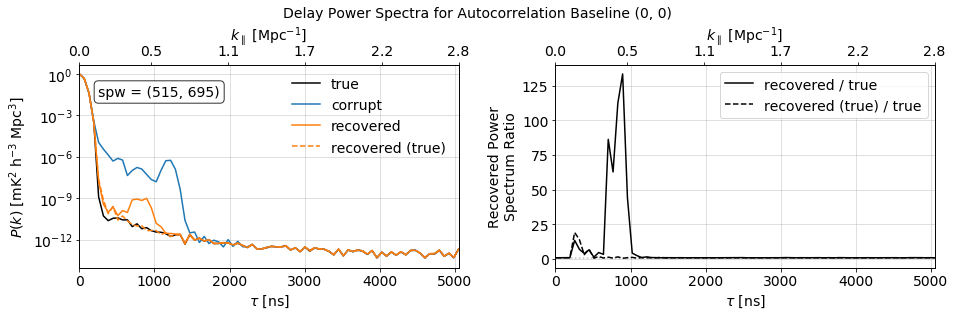

In [27]:
bl = (0, 0)
plot_time_averaged_pspec_spectra(uvps_tavg, params, metadata_dic,
                                 cosmo, bl_dic, bl=bl, peak_norm=True,
                                 spw_ind=1, top=0.8)

**Figure 6** | Autocorrelation delay power spectra for the true (black), corrupted (blue; true + systematics),  recovered (orange; corrupted data run through the systematics pipeline), and recovered (true) (dashed orange; true data that has been run through the systematics pipeline).  Suppression of the reflection terms in the autos by a factor of order 100 is visible, but there are residual reflections visible at delays just shy of 800 - 1000 ns.

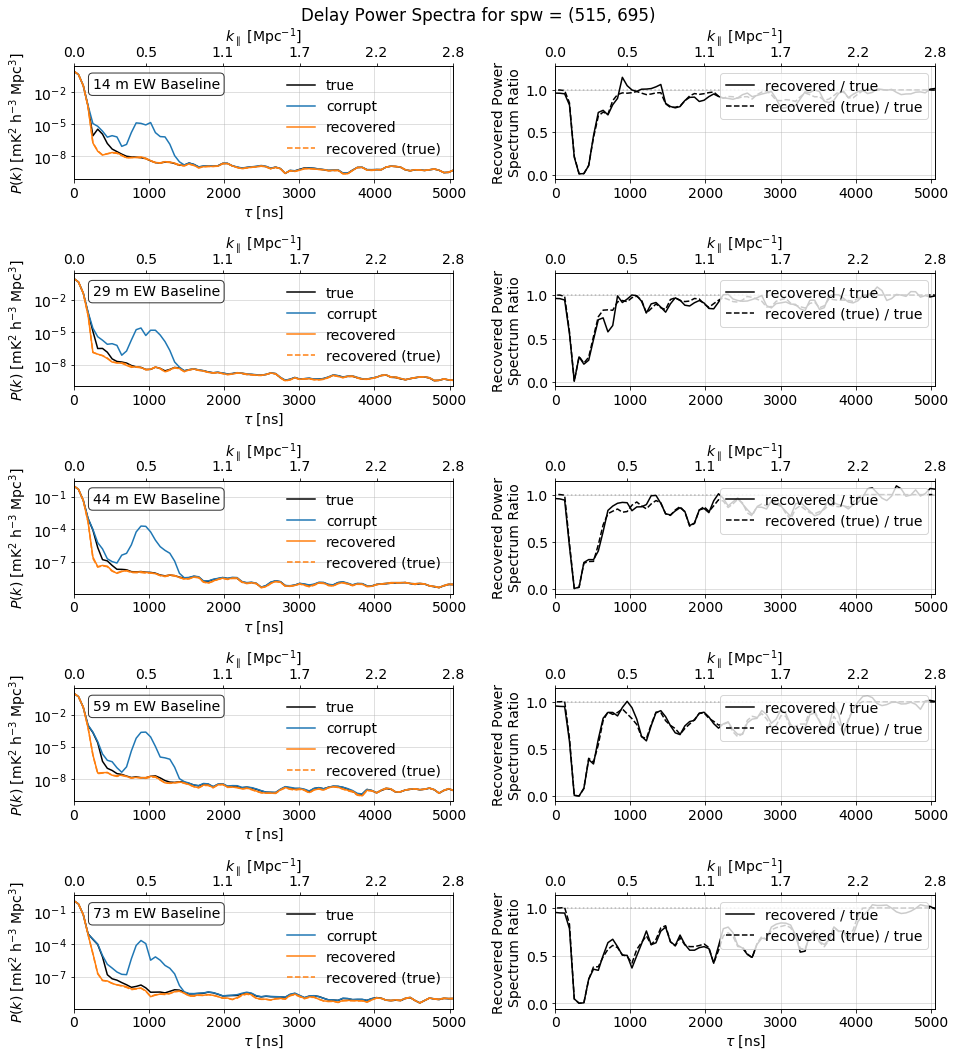

In [28]:
bl = list(bl_dic.keys())
plot_time_averaged_pspec_spectra(uvps_tavg, params, metadata_dic,
                                 cosmo, bl_dic, bl=bl, peak_norm=True,
                                 spw_ind=1, top=0.925)

**Figure 7** | (Left) Time averaged delay power spectra for the spw being used for H1C IDR2.2 upper limits, `spw=(515, 695)`. Plotted as the colored lines are the power spectra corresponding to the true (black), corrupt (blue), recovered (orange), and recovered (true) (dashed orange) datasets for five different EW baselines.  (Right) Ratios of recovered and input power spectra.  The delay at which the recovered power spectrum agrees with the true power spectrum seems to increase as a function of increasing EW baseline length.  This is likely an artifact due to the lack of noise in these datasets, whereas the parameters used for the mutual coupling systematic were optimized for noisy datasets.

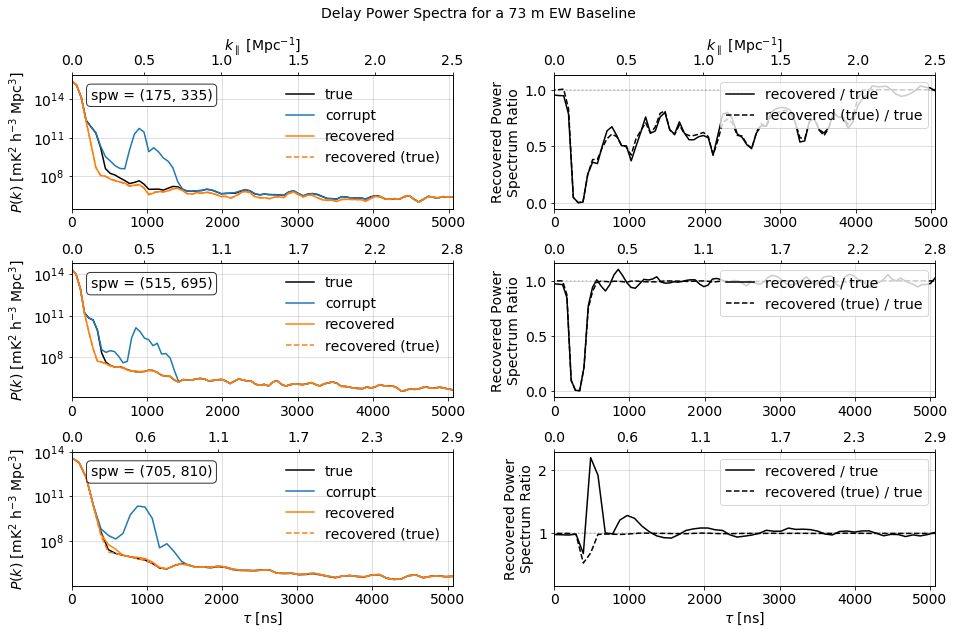

In [29]:
bl = (36, 41)
plot_time_averaged_pspec_spectra(uvps_tavg, params, metadata_dic,
                                 cosmo, bl_dic, bl=bl, top=0.875)

**Figure 8** | (Left) Time averaged delay power spectra for three spws (one spw per row). Plotted as the colored lines are the power spectra corresponding to the true (black), corrupt (blue), recovered (orange), and recovered (true) (orange dashed) datasets for a 73 m EW baseline.  (Right) Ratios of recovered and input power spectra.  The central spw (515, 695) shows the best performance in regards to the signal loss induced by the mutual coupling filter.  There is substantial signal loss near the pitchfork, but this is expected as discussed in the summary in section 1.1.4.